# REPORTING Ver 3
- All the heatmap bacgrounds are set to the same color. (0)
- All the heatmaps (except SHAP) aligned so that the lowest value shows the most impacted area

# imports

In [1]:
import pandas as pd
import numpy as np
import nibabel as nib   #YT: neuroimaging libary in python
from tqdm import tqdm
import logging
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import time
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import sys
import os
from sklearn.model_selection import train_test_split
import models           #YT .py file that defines the models
# YT .py file that creates the batches for training. I did not implemented as all data is already in the memory.
# Can be used again if batch generation needed for more larger datasets
#import utils  
import tensorflow as tf
from tensorflow import keras
from skimage.transform import rotate
from tensorflow.keras.utils import to_categorical

from functools import partial
from tensorflow.keras.layers import Input, Conv3D, Dense, MaxPool3D,BatchNormalization, Activation
from tensorflow.keras.layers import Add, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from datetime import datetime

from skimage.transform import resize
import shap
import glob
import copy

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)


if os.name=="nt" :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
else :
    os.environ['CUDA_VISIBLE_DEVICES']="0"

# Data path and file name definitions

In [2]:
outputpath = os.path.join(os.curdir, "results_resnet")    #YT: Papers results dir. Not used so far. Kept for legacy
root_logdir = os.path.join(os.curdir, "my_logsv2")          #YT: Added for TensorBoard logs
datapath = os.path.join(os.curdir, "images")              #YT: Added for the images. 

#YT added for TensorBoard logs Time stamps not a good descriptive naming think of a better one!
def get_run_logdir(mod):
    import time
    run_id = time.strftime("%m_%d-%H_%M")
    run_id = mod["model"][0:3]+mod["dset1"]+mod["dset2"]+str(mod["batch_size"])+"_"+mod["sActivation"]+run_id
    return os.path.join(root_logdir, run_id)



# Load Data
    Parameters
    ----------
    first_class : {'AD', 'LMCI', 'EMCI', 'Normal'}
        String label for target == 0.
    second_class : {'AD', 'LMCI', 'EMCI', 'Normal'}
        String label for target == 1.
    results_folder : string
        Folder to store results.
    
    Returns
    -------
        nump : data     (tf.dataset: switched back to numpy as I had issues to implement "sparse categorical with this new dataset. Will look into that later)
        numpy: targets for given data classes.



In [3]:
#YT Papers origional code
def LoadData(first_class, second_class, results_folder):

    results_folder= os.path.join(outputpath,'ad_vs_norm')
    metadata_fname = os.path.join(datapath,'metadata.csv')

    if first_class not in {'AD', 'LMCI', 'EMCI', 'CN'}:
        msg = "First class must be 'AD', 'LMCI', 'EMCI' or 'Normal', not {0}"
        raise ValueError(msg.format(first_class))
    
    if second_class not in {'AD', 'LMCI', 'EMCI', 'CN'}:
        msg = "Second class must be 'AD', 'LMCI', 'EMCI' or 'Normal', not {0}"
        raise ValueError(msg.format(second_class))
        
    if first_class == second_class:
        raise ValueError("Class labels should be different")
        
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    metadata = pd.read_csv(metadata_fname)
    smc_mask = ((metadata.Label == first_class) |
                (metadata.Label == second_class)).values.astype('bool')
    data = np.zeros((smc_mask.sum(), 1, 110, 110, 110), dtype='float32')
    target = (metadata[smc_mask].Label == second_class).values.astype('int32')
    for it, im in tqdm(enumerate(metadata[smc_mask].Path.values),
                      total=smc_mask.sum(), desc='Reading MRI to memory'):
        mx = nib.load(os.path.join(datapath,im)).get_fdata().max(axis=0).max(axis=0).max(axis=0)
        data[it, 0, :, :, :] = np.array(nib.load(os.path.join(datapath,im)).get_fdata()) / mx

# YT: Last column of the tf dataset is class label. It has to be float 32 as well        
#    data = np.concatenate((data,target),axis=1)        
#    data_tf = tf.convert_to_tensor(data, np.float32)

    return data, target

# Load and Test data  

In [4]:
if (True) :
    data, target = LoadData("AD", "CN","ad_cn")
    print (data.shape, target.shape)
    print (target)

Reading MRI to memory: 100%|██████████| 112/112 [00:04<00:00, 26.07it/s]

(112, 1, 110, 110, 110) (112,)
[1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0
 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1
 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1
 1]


In [5]:
if (Tr) :
    nData = 2
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    matr = rotate(data[nData,0,:,:, 60].reshape(110, 110), 90)
    plt.imshow(matr, cmap="gray")

    plt.subplot(1, 3, 2)
    matr = rotate(data[nData,0, :, 60, :].reshape(110, 110), 90)
    plt.imshow(matr, cmap="gray")


    plt.subplot(1, 3, 3)
    matr = rotate(data[nData,0,60, :, :].reshape(110, 110), 90)
    plt.imshow(matr, cmap="gray")
    #cbar = plt.colorbar()
    plt.show()  

# Define Models

Need to check more on these for performance. Seems like if the batch size issue can be resolved the architecture works better with learning and batchnorm activation RELU. 

From Paper: We train the final
binary classification models using Nesterov momentum with
learning rate of 10􀀀4 and batchsize of 3 for 70 epochs 

Their reference paper says: Batch normalization layers are inserted into the architecture intermediately for reducing
internal covariate shift [12], hence accelerate the training process and improve the performance. In
our network, the rectified linear units, i.e., f(x) = max(0; x), are utilized as the activation function
for non-linear transform [15].


## ResNet

In [6]:
#####         YT  ###############################################
#####   The resnet model definition in the book is much smarter. Can be used to reduce the code
#####   Layer names are same as the origional paper one

def Build_VoxResNet (bTrainBN=True, bTrainCnv=True, sActivation = 'relu', bTrainDnn=True):
#input     
    tf.keras.backend.clear_session()
    input_shape = (1,110,110,110)   

    inputs = Input(input_shape, name='input')               

    x = Conv3D(32, kernel_size=3, strides=1, padding='same',data_format="channels_first", name='conv1a', trainable = bTrainCnv) (inputs)
    x = BatchNormalization(name='bn1a', trainable = bTrainBN) (x)
    x = Activation(sActivation,name='relu1a')(x)
    
    x = Conv3D(32, kernel_size=3, strides=1, padding='same',data_format="channels_first", name='conv1b', trainable = bTrainCnv) (x)
    x = BatchNormalization(name='bn1b', trainable = bTrainBN) (x)
    x = Activation(sActivation,name='relu1b')(x)

    add1 = Conv3D(64, kernel_size=3, strides=2, padding='same',data_format="channels_first", name='conv1c') (x)

#VoxResBlock2
    x = BatchNormalization(name="voxres2_bn1", trainable = bTrainBN) (add1)
    x = Activation(sActivation,name="voxres2_relu1")(x)
    x = Conv3D(64, kernel_size=3, strides=1, padding='same',data_format="channels_first",name="voxres2_conv1",trainable = bTrainCnv) (x)
    x = BatchNormalization(name="voxres2_bn2", trainable = bTrainBN) (x)
    x = Activation(sActivation,name="voxres2_relu2")(x)
    add2 = Conv3D(64, kernel_size=3, strides=1, padding='same',data_format="channels_first",name="voxres2_conv2", trainable = bTrainCnv) (x)
    
    #addition
    add3 = Add(name="voxres2_out")([add1, add2])
    #print (add3.shape)

#VoxResBlock3
    x = BatchNormalization(name="voxres3_bn1", trainable = bTrainBN) (add3)
    x = Activation(sActivation, name="voxres3_relu1")(x)
    x = Conv3D(64, kernel_size=3, strides=1, padding='same', trainable = bTrainCnv,
               data_format="channels_first",name="voxres3_conv1") (x)
    x = BatchNormalization(name="voxres3_bn2", trainable = bTrainBN) (x)
    x = Activation(sActivation,name="voxres3_relu2")(x)
    add4 = Conv3D(64, kernel_size=3, strides=1, padding='same',
                  data_format="channels_first",name="voxres3_conv2", trainable = bTrainCnv) (x)

    #addition
    x = Add(name="voxres3_out")([add3, add4])

#block 4
    x = BatchNormalization(name="bn4", trainable = bTrainBN) (x)
    x = Activation(sActivation,name="relu4")(x)
    add5 = Conv3D(64, kernel_size=3, strides=2, padding='same',
                  data_format="channels_first", name="conv4", trainable = bTrainCnv) (x)

#VoxResBlock5
    x = BatchNormalization(name="voxres5_bn1", trainable = bTrainBN) (add5)
    x = Activation(sActivation,name="voxres5_relu1")(x)
    x = Conv3D(64, kernel_size=3, strides=1, padding='same',
               data_format="channels_first",name="voxres5_conv1", trainable = bTrainCnv) (x)
    x = BatchNormalization(name="voxres5_bn2", trainable = bTrainBN) (x)
    x = Activation(sActivation,name="voxres5_relu2")(x)
    add6 = Conv3D(64, kernel_size=3, strides=1, padding='same',
                  data_format="channels_first", name="voxres5_conv2", trainable = bTrainCnv) (x)
    
    #addition
    add7 = Add(name="voxres5_out")([add5, add6])

#VoxResBlock6
    x = BatchNormalization(name="voxres6_bn1", trainable = bTrainBN) (add7)
    x = Activation(sActivation,name="voxres6_relu1")(x)
    x = Conv3D(64, kernel_size=3, strides=1, padding='same',
               data_format="channels_first",name="voxres6_conv1", trainable = bTrainCnv) (x)
    x = BatchNormalization(name="voxres6_bn2", trainable = bTrainBN) (x)
    x = Activation(sActivation,name="voxres6_relu2")(x)
    add8 = Conv3D(64, kernel_size=3, strides=1, padding='same',
                  data_format="channels_first",name="voxres6_con2", trainable = bTrainCnv) (x)

    #addition
    x = Add(name="voxres6_out")([add7, add8])

#block 7
    x = BatchNormalization(name="bn7", trainable = bTrainBN) (x)
    x = Activation(sActivation,name="relu7")(x)
    add9 = Conv3D(128, kernel_size=3, strides=2, padding='same',
                  data_format="channels_first",name="conv7", trainable = bTrainCnv) (x)

#VoxResBlock8
    x = BatchNormalization(name="voxres8_bn1", trainable = bTrainBN) (add9)
    x = Activation(sActivation,name="voxres8_relu1")(x)
    x = Conv3D(128, kernel_size=3, strides=1, padding='same',
               data_format="channels_first",name="voxres8_conv1", trainable = bTrainCnv) (x)
    x = BatchNormalization(name="voxres8_bn2", trainable = bTrainBN) (x)
    x = Activation(sActivation,name="voxres8_relu2")(x)
    add10 = Conv3D(128, kernel_size=3, strides=1, padding='same',
                  data_format="channels_first",name="voxres8_conv2", trainable = bTrainCnv) (x)
    
#addition
    add11 = Add(name="voxres8_out")([add9, add10])

#VoxResBlock9
    x = BatchNormalization(name="voxres9_bn1", trainable = bTrainBN) (add11)
    x = Activation(sActivation,name="voxres9_relu1")(x)
    x = Conv3D(128, kernel_size=3, strides=1, padding='same',
               data_format="channels_first",name="voxres9_conv1", trainable = bTrainCnv) (x)
    x = BatchNormalization(name="voxres9_bn2", trainable = bTrainBN) (x)
    x = Activation(sActivation,name="voxres9_relu2")(x)
    add12 = Conv3D(128, kernel_size=3, strides=1, padding='same',
                  data_format="channels_first",name="voxres9_conv2", trainable = bTrainCnv) (x)

    #addition
    add13 = Add(name="voxres9_out")([add11, add12])


#block 10
    x = MaxPool3D (pool_size=7,data_format="channels_first",name="pool10") (add13) 

#block 11
    
  #YT: Lasagna Dense works different than Keras Dense  
  #flatten trailing axes (into (n+1)-tensor for num_leading_axes=n)
  #input = input.flatten(num_leading_axes + 1)  
    x = Flatten(data_format="channels_first", name="flat11")(x)                
                                    
    print("dense :", x.shape)
    x= Dense(128, activation="relu", name="fc11", trainable=bTrainDnn)(x)
 
    if (mod['bDropout' ]):
        x = Dropout(0.5)(x)

    if (mod['bAddDense']) :
        x = Dense(64, activation="relu", trainable=bTrainDnn)(x)

    #x = Dropout(0.5)(x)
    
    output = Dense(2, activation="softmax", name="prob")(x)
    print ("output : ",output.shape)

    model = Model(inputs=[inputs], outputs=[output])   

    return model



## VoxCNN

In [7]:

####YT  builds the VoxCNN model as defined in the paper
def Build_VoxCNN (bTrainBN=True, bTrainCnv=True, sActivation = 'relu', bTrainDnn=True, nDropOut=0.5):

    tf.keras.backend.clear_session()
   
    input_shape = (1,110,110,110)   

    inputs = Input(input_shape, name='input')               


    nn = Conv3D (8, kernel_size=3, strides=1, padding='same', activation = 'relu',
                  data_format="channels_first", trainable = bTrainCnv) (inputs)
    nn = Conv3D (8, kernel_size=3, strides=1, padding='same',activation = 'linear',
                  data_format="channels_first", trainable = bTrainCnv) (nn)
    nn = Activation(sActivation)(nn)
    nn = MaxPool3D (pool_size=2,data_format="channels_first") (nn) 

    nn = Conv3D (16, kernel_size=3, strides=1, padding='same', activation = 'relu',
                  data_format="channels_first", trainable = bTrainCnv) (nn)
    nn = Conv3D (16, kernel_size=3, strides=1, padding='same',activation = 'linear',
                  data_format="channels_first", trainable = bTrainCnv) (nn)
    nn = Activation(sActivation)(nn)
    nn = MaxPool3D (pool_size=2,data_format="channels_first") (nn) 

    nn = Conv3D (32, kernel_size=3, strides=1, padding='same', activation = 'relu',
                  data_format="channels_first", trainable = bTrainCnv) (nn)
    nn = Conv3D (32, kernel_size=3, strides=1, padding='same', activation = 'relu',
                  data_format="channels_first", trainable = bTrainCnv) (nn)
    nn = Conv3D (32, kernel_size=3, strides=1, padding='same',activation = 'linear',
                  data_format="channels_first", trainable = bTrainCnv) (nn)
    nn = Activation(sActivation)(nn)
    nn = MaxPool3D (pool_size=2,data_format="channels_first") (nn) 

    nn = Conv3D (64, kernel_size=3, strides=1, padding='same', activation = 'relu',
                  data_format="channels_first", trainable = bTrainCnv) (nn)
    nn = Conv3D (64, kernel_size=3, strides=1, padding='same', activation = 'relu',
                  data_format="channels_first", trainable = bTrainCnv) (nn)
    nn = Conv3D (64, kernel_size=3, strides=1, padding='same',activation = 'linear',
                  data_format="channels_first", trainable = bTrainCnv) (nn)
    nn = Activation(sActivation)(nn)

    nn = MaxPool3D (pool_size=2,data_format="channels_first") (nn) 

    nn = Flatten(data_format="channels_first")(nn)                
                                    
    nn= Dense(128, activation="relu", trainable=bTrainDnn)(nn)
    nn = BatchNormalization(trainable = bTrainBN) (nn)
    nn = Dropout(nDropOut)(nn)

    nn= Dense(64, activation="relu", trainable=bTrainDnn)(nn)
    
#    nn = BatchNormalization(trainable = bTrainBN) (nn)
#    nn = Dropout(0.5)(nn)
    
    output = Dense(2, activation="softmax")(nn)
    
    print ("output : ",output.shape)

    model = Model(inputs=[inputs], outputs=[output])   
    
    return model
    
   

In [8]:

def DefineResNetModel(mod) :
    ResNet3D = Build_VoxResNet(mod['bTrainBN'], mod['bTrainCnv'], mod['sActivation'], mod['bTrainDnn'])
    opt = tf.keras.optimizers.SGD(mod['lr_all'], mod['momentum'], nesterov=True)
    ResNet3D.compile(optimizer= opt, loss=['categorical_crossentropy'], 
                  metrics=['accuracy', 'AUC'])
    return ResNet3D

In [9]:
def DefineVoxCNNModel(mod) :
    ResNet3D = Build_VoxCNN(mod['bTrainBN'], mod['bTrainCnv'], mod['sActivation'], mod['bTrainDnn'], mod['nDropOut'])
    opt = tf.keras.optimizers.Adam(mod['lr_all'])
    ResNet3D.compile(optimizer= opt, loss=['categorical_crossentropy'], 
                  metrics=['accuracy', 'AUC'])
    return ResNet3D

## Print Graph and Table

In [10]:
def Plot_Graph(val, label, title) :

    mn = np.mean(val,axis=0)
    st = np.std(val,axis=0)
    
    #print (title, label, val, mn, st)

    plt.plot(mn,'r-+',linewidth=2.0, label=label)
    plt.fill_between(np.linspace(0,mn.shape[0],mn.shape[0]),y1=mn-st,y2=mn+st, alpha=0.25) 
    
    plt.legend(loc='best')
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.title(title)
    plt.show()

    

In [11]:
def report_Paper (mod, list_histories, run_logdir):
    
    mx_val_scores = [np.max(list_histories[i].history['val_accuracy']) for i in range(len(list_histories))]
    histories = [h.history for h in list_histories]
    print("Max val scores", mx_val_scores)
    print("Mean+Std stats", np.mean(mx_val_scores), np.std(mx_val_scores))

    mx_AUC_scores = [np.max(list_histories[i].history['val_AUC']) for i in range(len(list_histories))]
    print("Max AUC scores", mx_AUC_scores)
    print("Mean+Std stats", np.mean(mx_AUC_scores), np.std(mx_AUC_scores))
    
        
    #Plot VAL MEAN+STD    
    val_acc = np.array([ v['val_accuracy'] for v in histories]) 
    Plot_Graph (val_acc, 'val_acc', 'Mean of validation accuracy')
    val_AUC = np.array([ v['val_AUC'] for v in histories]) 
    Plot_Graph (val_AUC, 'val_AUC', 'Mean of AUC')
        

# Parameter definitions
dset1, dset2 : AD = Alzheimer's Disease, LMCI = Late Mild Cognitive Impairement, EMCI = Early Mild Cognitive Impairement, CN = Normal Cohort
model: resnet, voxcnn

For Resnet when is set to False, batch size can be increased without resource issues. Add after the tests




In [54]:
mod={'dset1': "AD", 'dset2': "CN",  
'Epochs':1, 'batch_size':5,'repeats':1, 'nSplit': 5,  'bUseTensorBoard' : False,   #YT run params
'lr_all':0.0004, 'momentum' : 0.9, 'bTrainBN' : False, 'bTrainCnv' : True, 'bTrainDnn' : True, #YT ResNet params 
'sActivation' : 'relu', 'model':'resnet', 'bDropout' : False, 'bAddDense':False, #YT ResNet params
#'lr_all':0.000027, 'momentum' : 0.9, 'bTrainBN' :True, 'bTrainCnv' : True, 'bTrainDnn' : True, #YT ResNet params 
#'sActivation' : 'relu', 'nDropOut' : 0.7, 'model':'voxcnn',  #YT VoxCNN params
'bOcclusion': False  #YT Runs the occlusion for the last model fitted.   
    }
mod.keys()

dict_keys(['dset1', 'dset2', 'Epochs', 'batch_size', 'repeats', 'nSplit', 'bUseTensorBoard', 'lr_all', 'momentum', 'bTrainBN', 'bTrainCnv', 'bTrainDnn', 'sActivation', 'model', 'bDropout', 'bAddDense', 'bOcclusion'])

# Load Models

In [13]:
if mod['model'] =='voxcnn' :
    modelRN = DefineVoxCNNModel (mod)
    modelRN.load_weights(os.path.join(outputpath,"voxcnnADCN5_20200501-145937_bestW.hdf5")) #Best weights so far
else :
    modelRN = DefineResNetModel (mod)
    modelRN.load_weights(os.path.join(outputpath,"resnetADCN5_20200501-032129_bestW.hdf5")) #Best weights so far
    
modelRN.summary()

output :  (None, 2)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 110, 110, 110) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 8, 110, 110, 110)  224       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 110, 110, 110)  1736      
_________________________________________________________________
activation (Activation)      (None, 8, 110, 110, 110)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 55, 55, 55)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 55, 55, 55)    3472      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 16, 5

# Reporting

## Report from npz

In [14]:

def conv2RunVars (Results) :
    mx_val = Results['max_val']
    histories = Results['hists']
    mx_ROC = Results['max_ROC']
    mod = Results['settings'].item()
    return mod, mx_val, mx_ROC, histories, 

In [15]:
def Plot2Graphs(val1, val2, label1, label2, title) :

    mn1 = np.mean(val1,axis=0)
    st1 = np.std(val1,axis=0)
    mn2 = np.mean(val2,axis=0)
    st2 = np.std(val2,axis=0)

    plt.plot(mn1,'r-+',linewidth=2.0,label=label1)
    plt.fill_between(np.linspace(0,mn1.shape[0],mn1.shape[0]),y1=mn1-st1,y2=mn1+st1, alpha=0.25) 
    plt.plot(mn2,'g-o',linewidth=2.0,label=label2)
    plt.fill_between(np.linspace(0,mn2.shape[0],mn2.shape[0]),y1=mn2-st2,y2=mn2+st2, alpha=0.25) 
    plt.legend(loc='best')
    plt.ylabel('mean accuracy')
    plt.xlabel('epoch')
    plt.title(title)



In [16]:
if (True) :
    resultsRN = np.load(os.path.join(outputpath, "resnetADCN4_20200422-093850_results.npz"),allow_pickle=True)
    resultsCN = np.load(os.path.join(outputpath, "voxcnnADCN5_20200422-223024_results.npz"),allow_pickle=True)
    modRN, max_valRN, max_ROCRN, historiesRN = conv2RunVars (resultsRN)
    modCN, max_valCN, max_ROCCN, historiesCN = conv2RunVars (resultsCN)

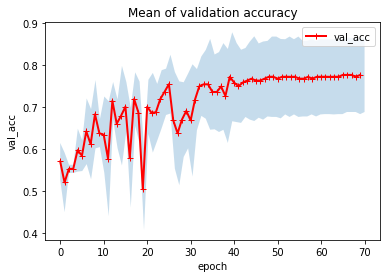

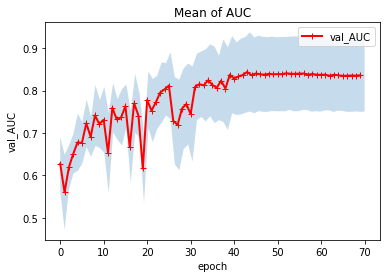

In [17]:
#Plot VAL MEAN+STD    
val_acc = np.array([ v['val_accuracy'] for v in historiesRN]) 
Plot_Graph (val_acc, 'val_acc', 'Mean of validation accuracy')
val_AUC = np.array([ v['val_AUC'] for v in historiesRN]) 
Plot_Graph (val_AUC, 'val_AUC', 'Mean of AUC')


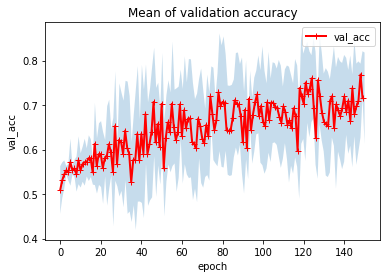

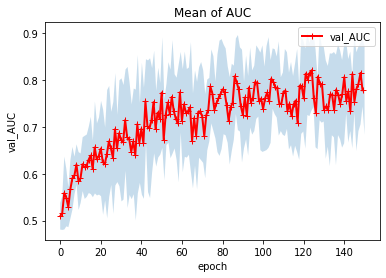

In [18]:
#Plot VAL MEAN+STD    
val_acc2 = np.array([ v['val_accuracy'] for v in historiesCN]) 
Plot_Graph (val_acc2, 'val_acc', 'Mean of validation accuracy')
val_AUC2 = np.array([ v['val_AUC'] for v in historiesCN]) 
Plot_Graph (val_AUC2, 'val_AUC', 'Mean of AUC')

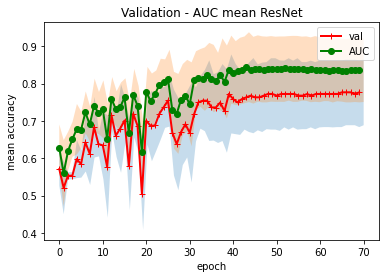

In [19]:
Plot2Graphs(val_acc, val_AUC, "val", "AUC", "Validation - AUC mean ResNet")

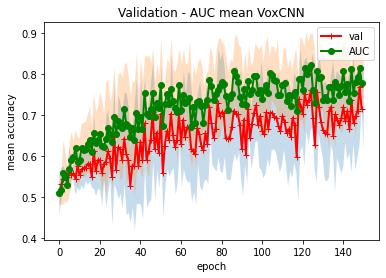

In [20]:
Plot2Graphs(val_acc2, val_AUC2, "val", "AUC", "Validation - AUC mean VoxCNN")

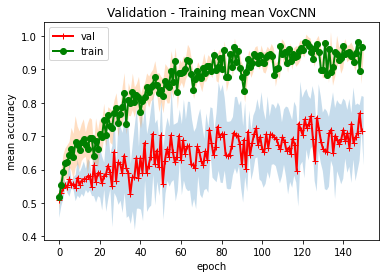

In [21]:
acc2 = np.array([ v['accuracy'] for v in historiesCN]) 
Plot2Graphs(val_acc2, acc2, "val", "train", "Validation - Training mean VoxCNN")

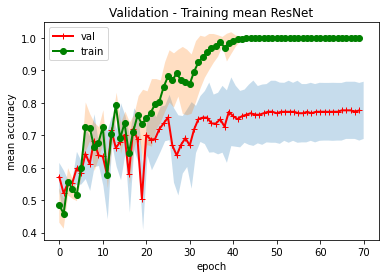

In [22]:
acc = np.array([ v['accuracy'] for v in historiesRN]) 
Plot2Graphs(val_acc, acc, "val", "train", "Validation - Training mean ResNet")

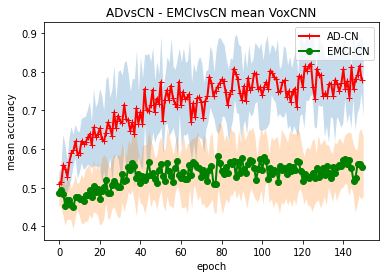

In [23]:
resultsEM = np.load(os.path.join(outputpath, "voxcnnEMCICN5_20200424-191512_results.npz"),allow_pickle=True)
modEM, max_valEM, max_ROCEM, historiesEM = conv2RunVars (resultsEM)
val_AUCEM = np.array([ v['val_AUC'] for v in historiesEM]) 
Plot2Graphs(val_AUC2, val_AUCEM, "AD-CN", "EMCI-CN", "ADvsCN - EMCIvsCN mean VoxCNN")

## Function for heatmap calculation !!!! Runs very very very long 

This is the place where categorical cross entropy is used!

"""
    Parameters
    ----------
    net : Lasagne Layer
        The neural net to test.
    x : np.array
        The input data, should be of shape (1, c, x, y, z).
    label : int
        Sample label
    square_size : int, optional (default=7)
        The length of the side of the square that occludes the image.
    batchsize : int, optional (default=1)
        Number of images in batch for inference pass.
        
    Results
    -------
    np.array
        3D np.array that at each point (i, j) contains the predicted
        probability of the correct class if the image is occluded by a
        square with center (i, j).
    """

In [24]:
#YT Papers origional code
def occlusion_heatmap(net, x, label, square_size=7, batchsize=1):
    
    if (x.ndim != 5) or x.shape[0] != 1:
        raise ValueError("This function requires the input data to be of shape"
                         " (1, c, x, y, z), instead got {}".format(x.shape))
    if square_size % 2 == 0:
        raise ValueError("Square length has to be an odd number, instead "
                         "got {}.".format(square_size))

    num_classes = 2
    img = x[0].copy()
    bs, col, s0, s1, s2 = x.shape

    pad = square_size // 2 + 1
    x_occluded = np.zeros((s2, col, s0, s1, s2), dtype=img.dtype)
    probs = np.zeros((s0, s1, s2, num_classes))

    for i in range(s0):
        for j in tqdm(range(s1), desc='x = {}'.format(i)):
            batch_iter = 1
            batch = []
            for k in range(s2):
                x_pad = np.pad(img, ((0, 0), (pad, pad),
                                     (pad, pad), (pad, pad)), 'constant')
                x_pad[:,
                      i:i + square_size,
                      j:j + square_size,
                      k:k + square_size] = 0.
                x_occluded = x_pad[:, pad:-pad, pad:-pad, pad:-pad]
                batch.append(x_occluded)
                if batch_iter % batchsize == 0:
                    y_proba = net.predict_on_batch(np.array(batch).reshape((-1, 1, 110, 110, 110)))
                    probs[i, j, k - batchsize + 1:k + 1, :] = y_proba
                    batch_iter = 0
                    batch = []
                batch_iter += 1

    return probs

In [25]:
#YT Papers origional code
if (False) :
    res_oc_eg = occlusion_heatmap(modelRN, mri.reshape(1, 1, 110, 110, 110), 0, 7, 11)
    np.save ("vox_example", res_oc_eg)
#    np.save ("data_2",data[2])


In [26]:

def Print2Slices(pic, ptype, color="gray") :
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')

    if (ptype=='res'):
        matr = rotate(pic[:, :, 47, 0].reshape(110, 110), 90)
    elif (ptype=='data') or (ptype=='shap'):
        matr = rotate(pic[:, :, :, 47].reshape(110, 110), 90)
        
    if (ptype=='shap') :
        plt.imshow(matr)
    else:
        if color == "gray" :    
            plt.imshow(matr, cmap = "gray")
        else :
            plt.imshow(matr)
        
    plt.subplot(1, 2, 2)
    plt.axis('off')

    if (ptype=='res'):
        matr = rotate(pic[57, :, :, 0].reshape(110, 110), 90)
    elif (ptype=='data') or (ptype=='shap'):
        matr = rotate(pic[:, 57, :, :].reshape(110, 110), 90)

        
    if (ptype=='shap') :
        plt.imshow(matr)
    else :
        if color == "gray"  :         
            plt.imshow(matr, cmap = "gray")
        else :
            plt.imshow(matr)
#    plt.hold(True)

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()

In [27]:
def PrintOcclusion (data, res) :
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')

    matr = rotate(data[:, :, :, 47].reshape(110, 110), 90)
    plt.imshow(matr, "gray")
#    plt.hold(True)

    matr = rotate(res[:, :, 47, 0].reshape(110, 110), 90)
    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.68, matr)),
           interpolation=None, vmax=1., vmin=.0, alpha=.8,
           cmap=plt.cm.viridis_r)
    
    plt.subplot(1, 2, 2)
    plt.axis('off')

    matr = rotate(data[:, 57, :, :].reshape(110, 110), 90)
    plt.imshow(matr, cmap="gray")
#    plt.hold(True)

    matr = rotate(res[57, :, :, 0].reshape(110, 110), 90)
    plt.imshow(200. * (1 - np.ma.masked_where(matr > .68, matr)),
           interpolation=None, vmax=1., vmin=.0, alpha=.8,
           cmap=plt.cm.viridis_r)
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()

In [28]:
def Print3Slices (pic, ptype, color="gray"):

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    
    if (ptype == "data") or (ptype == "shap"):
        matr = rotate(pic[0,:,:, 60].reshape(110, 110), 90)
    elif (ptype=="res"):
        matr = rotate(pic[:,:,60,0].reshape(110, 110), 90)
        
    if color == "gray" : 
        plt.imshow(matr, cmap="gray")
    else:
        plt.imshow(matr)

    plt.subplot(1, 3, 2)
    if (ptype == "data") or (ptype == "shap"):
        matr = rotate(pic[0, :, 60, :].reshape(110, 110), 90)
    elif (ptype=="res"):
        matr = rotate(pic[:,60,:, 0].reshape(110, 110), 90)
    
    if color == "gray" : 
        plt.imshow(matr, cmap="gray")
    else:
        plt.imshow(matr)


    plt.subplot(1, 3, 3)
    if (ptype == "data") or (ptype == "shap"):
        matr = rotate(pic[0,60, :, :].reshape(110, 110), 90)
    elif (ptype=="res"):
        matr = rotate(pic[60,:,:,0].reshape(110, 110), 90)
    
    if color == "gray" : 
        plt.imshow(matr, cmap="gray")
    else:
        plt.imshow(matr)

    #cbar = plt.colorbar()
    plt.show() 

In [29]:
if (False):
    res = np.load ("resnp.npy")

In [30]:
TestData = data[20:30]
ntarget = modelRN.predict(TestData)

In [31]:
ntarget

array([[0.68963647, 0.3103635 ],
       [0.7398334 , 0.26016656],
       [0.6964908 , 0.3035092 ],
       [0.30225873, 0.6977412 ],
       [0.2185907 , 0.78140926],
       [0.315465  , 0.68453497],
       [0.7229946 , 0.27700537],
       [0.22607449, 0.7739255 ],
       [0.3026062 , 0.6973938 ],
       [0.85576594, 0.14423409]], dtype=float32)

In [32]:
#Print2Slices(data[2],"data","gray")
Print2Slices(res_oc_eg,"res","gray")
PrintOcclusion (data[2],res_oc_eg)

NameError: name 'res_oc_eg' is not defined

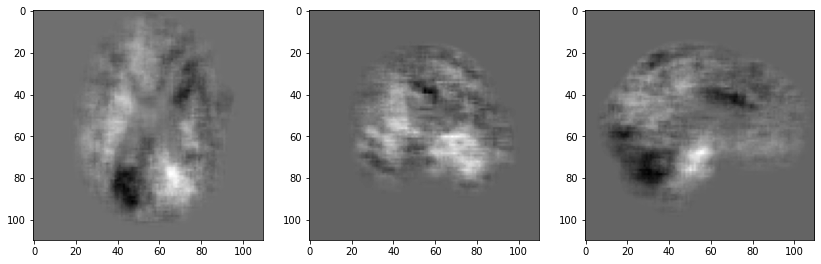

In [153]:
#Print3Slices(data[2],"data")
Print3Slices(res_oc_eg,"res")

## Shap Values

slundberg commented on Oct 17, 2019:

"The master version of SHAP now has support for TF 2.0 in GradientExplainer (not DeepExplainer yet). We get pushed in a release soon"

In [32]:
def Conv_Img2(shap_im) :
    #YT make 2D, then rotate 90 and add channel to the last axes
    p_im =  np.expand_dims(rotate(shap_im[0][57,:,:].reshape(110,110),90),axis=-1)
    return p_im

In [33]:
def Conv_Img (shap_im) :
    #YT make 2D, then rotate 90 and add channel to the last axes
    p_im =  np.expand_dims(rotate(shap_im[0][:,:,47].reshape(110,110),90),axis=-1)
    return p_im

In [34]:
#YT converts the current images of type channels x 3D images -----> 2DImages x channels
def Conv_ShapValue4Plot (shap_values, pixel_values) :
    shap_list = []
    for i in range (len(shap_values)):      
        shap_ar = np.array([Conv_Img(shap_values[i][j]) for j in range(shap_values[0].shape[0])])
        #print (shap_ar.shape)
        shap_list.append(shap_ar)
        #print (len(shap_list),shap_list[0].shape )
            
    data_img = np.array([Conv_Img(pixel_values[i]) for i in range(len(pixel_values))])
        
    return shap_list, data_img
    

In [35]:
#YT converts the current images of type channels x 3D images -----> 2DImages x channels
def Conv_ShapValue4Plot2 (shap_values, pixel_values) :
    shap_list = []
    for i in range (len(shap_values)):      
        shap_ar = np.array([Conv_Img2(shap_values[i][j]) for j in range(shap_values[0].shape[0])])
        #print (shap_ar.shape)
        shap_list.append(shap_ar)
        #print (len(shap_list),shap_list[0].shape )
            
    data_img = np.array([Conv_Img2(pixel_values[i]) for i in range(len(pixel_values))])
        
    return shap_list, data_img
    

In [36]:
target

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1])

In [37]:

import tensorflow.keras.backend as K

nExplain = 10
to_explain = data[20:30]

e = shap.GradientExplainer(modelRN,  data, batch_size=5)
#shap_values, index = e.shap_values(to_explain,ranked_outputs=2)
shap_values = e.shap_values(to_explain)


KeyboardInterrupt: 

In [ ]:
shap_values[0][0].shape

In [ ]:
# get the names for the classes
class_names = ['AD', 'CN']
indexes = np.array([["CN","AD"],["CN","AD"], ["AD","CN"],["AD","CN"],["AD","CN"],["CN","AD"],["CN","AD"],["AD","CN"],["AD","CN"],["CN","AD"]])
indexes.shape

In [77]:
shap_img, data_img = Conv_ShapValue4Plot (shap_values, data[0:nExplain])
shap.image_plot(shap_img, data_img,indexes)


IndexError: too many indices for array

In [ ]:
shap_img2, data_img = Conv_ShapValue4Plot2 (shap_values, data[0:nExplain])
shap.image_plot(shap_img2, data_img,labels=indexes)

# 3D-UCM

In [ ]:
mri.shape

In [1]:
def Calc3DUCM(model, mri):
    #level_list = glob.glob('vmages\3DUCM\example_level_*')
    path = '..\\vimages\\3DUCM'
    level_list = os.listdir(path)
    level_list.pop(0)
    print (level_list)
    prob_list = []
    for k in tqdm(range(len(level_list))):

        segname = os.path.join(path,level_list[k])
        segs = np.load(segname)
        segs = np.flipud(segs)

        s0, s1, s2 = mri.shape
        num_classes = 2
        probs = np.zeros((s0, s1, s2, num_classes))
        seg_array = np.unique(segs)

        for j in range(len(seg_array)):

            x_occluded = copy.deepcopy(mri)
            x_occluded[np.where(segs==seg_array[j])] = 0
            y_proba = model.predict(np.array(x_occluded).reshape((-1, 1, 110, 110, 110)), batch_size=5)
            probs[np.where(segs==seg_array[j])] = y_proba
            #print(y_proba)

        prob_list.append(probs)

    prob_map = np.zeros(mri.shape)

    for ll in range(len(prob_list)):
        prob_map = prob_map + prob_list[ll][:,:,:,0]

    prob_map = prob_map / np.float(len(prob_list))

    res = (prob_map - np.min(prob_map)) / (np.max(prob_map) - np.min(prob_map))
    
    return res

In [39]:
def Print3Gray() :
    fig = plt.figure(figsize=(21, 5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)

    plt.subplot(1, 3, 2)
    plt.axis('off')
    matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)

    plt.subplot(1, 3, 3)
    plt.axis('off')
    matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()    

In [40]:
def Calc3DUCM_Min(model, mri):
    #level_list = glob.glob('vmages\3DUCM\example_level_*')
    path = 'vimages\\3DUCM'
    level_list = os.listdir(path)
    level_list.pop(0)
    print (level_list)
    prob_list = []
    for k in tqdm(range(len(level_list))):

        segname = os.path.join(path,level_list[k])
        segs = np.load(segname)
        segs = np.flipud(segs)

        s0, s1, s2 = mri.shape
        num_classes = 2
        probs = np.zeros((s0, s1, s2, num_classes))
        seg_array = np.unique(segs)

        for j in range(len(seg_array)):

            x_occluded = copy.deepcopy(mri)
            x_occluded[np.where(segs==seg_array[j])] = 0
            y_proba = model.predict_on_batch(np.array(x_occluded).reshape((-1, 1, 110, 110, 110)))
            probs[np.where(segs==seg_array[j])] = y_proba
            #print(y_proba)

        prob_list.append(probs)

    prob_map = np.zeros(mri.shape)

    for i in range(s0):
        for j in range (s1):
            for k in range(s2):
                for ll in range(len(prob_list)):
                    if (prob_map[i][j][k] < prob_list[ll][i,j,k,0]) :
                        prob_map[i][j][k] = prob_list[ll][i,j,k,0]

 #   prob_map = prob_map / np.float(len(prob_list))

    res = (prob_map - np.min(prob_map)) / (np.max(prob_map) - np.min(prob_map))
    
    return res

In [41]:
def Print3DUCM(res):
    seg0_name = 'vimages\\3DUCM\\example_level_00.npy'
    seg0 = np.load(seg0_name)
    seg0 = np.flipud(seg0)
    seg0_array = np.unique(seg0)
    vox_cnt = []

    for cc in range(len(seg0_array)):
        vox_cnt.append(len(np.where(seg0==seg0_array[cc])[0]))
    bg_seg = seg0_array[np.where(np.array(vox_cnt) == max(vox_cnt))[0]][0]

    res[np.where(seg0==bg_seg)] = 0

    res = resize(res,(256,256,256))
  
    fig = plt.figure(figsize=(21, 5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()

In [42]:
def Print3Occ(res):

    seg0_name = 'vimages\\3DUCM\\example_level_00.npy'
    seg0 = np.load(seg0_name)
    seg0 = np.flipud(seg0)
    seg0_array = np.unique(seg0)
    vox_cnt = []

    for cc in range(len(seg0_array)):
        vox_cnt.append(len(np.where(seg0==seg0_array[cc])[0]))
    bg_seg = seg0_array[np.where(np.array(vox_cnt) == max(vox_cnt))[0]][0]

    res[np.where(seg0==bg_seg)] = 0

    res = resize(res,(256,256,256))

    fig = plt.figure(figsize=(21, 5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, alpha=.8,
           cmap=plt.cm.rainbow) 
#    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.56, matr)),
#           interpolation=None, vmax=1., vmin=.0, alpha=.8,
#           cmap=plt.cm.viridis_r)
 
    plt.subplot(1, 3, 2)
    plt.axis('off')
    matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0)
    #plt.hold(True)
    matr = rotate(res[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, alpha=.8,
           cmap=plt.cm.rainbow) 
#    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.56, matr)),
#           interpolation=None, vmax=1., vmin=.0, alpha=.8,
#           cmap=plt.cm.viridis_r)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, alpha=.8,
           cmap=plt.cm.rainbow) 
#    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.56, matr)),
#           interpolation=None, vmax=1., vmin=.0, alpha=.8,
#           cmap=plt.cm.viridis_r)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()

# GRAD CAM

In [43]:
def Calc_3D_Grad_CAM (model, mri, layer_name = 'conv3d_9') :
    LAYER_NAME = layer_name  #YT last convolutional layer
    CAT_CLASS_INDEX = 0

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(mri.reshape(1,1,110,110,110))
        loss = predictions[:, CAT_CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

#gate_f = tf.cast(output > 0, 'float32')
#gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(1,2,3)) #YT last dims

    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[2:5])

    for i, w in enumerate(weights):
        cam += w * output[i,:, :, :]

    res = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))   

    seg0_name = 'vimages\\3DUCM\\example_level_00.npy'
    seg0 = np.load(seg0_name)
    seg0 = np.flipud(seg0)
    seg0_array = np.unique(seg0)
    vox_cnt = []

    for cc in range(len(seg0_array)):
        vox_cnt.append(len(np.where(seg0==seg0_array[cc])[0]))
    bg_seg = seg0_array[np.where(np.array(vox_cnt) == max(vox_cnt))[0]][0]

    res = resize(res,(110,110,110))
    res[np.where(seg0==bg_seg)] = 0

    res[np.where(seg0==bg_seg)] = 0

    res = resize(res,(256,256,256))
    
    fig = plt.figure(figsize=(21, 5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()    
    
    return res


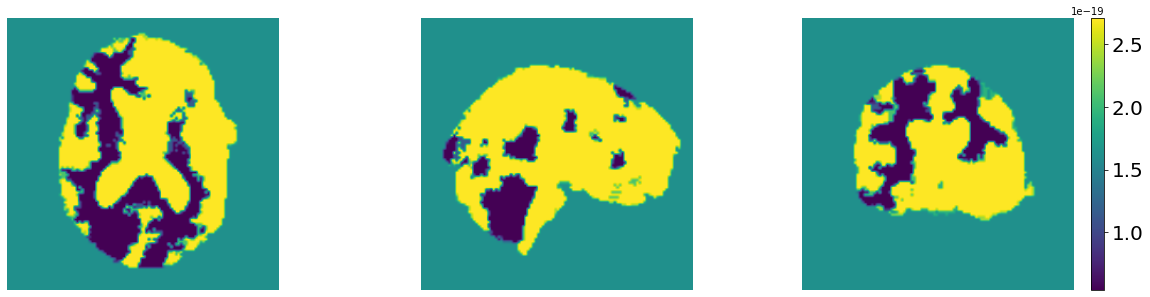

In [44]:
seg0_name = 'vimages\\3DUCM\\example_level_18.npy'
seg0 = np.load(seg0_name)
seg0 = np.flipud(seg0)

mri_rz = resize(seg0,(256,256,256))

fig = plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
plt.imshow(matr)
plt.subplot(1, 3, 2)
plt.axis('off')
matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
plt.imshow(matr)
plt.subplot(1, 3, 3)
plt.axis('off')
matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
plt.imshow(matr)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()

# REPORT MAIN

dense : (None, 1024)
output :  (None, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1, 110, 110, 0                                            
__________________________________________________________________________________________________
conv1a (Conv3D)                 (None, 32, 110, 110, 896         input[0][0]                      
__________________________________________________________________________________________________
bn1a (BatchNormalization)       (None, 32, 110, 110, 440         conv1a[0][0]                     
__________________________________________________________________________________________________
relu1a (Activation)             (None, 32, 110, 110, 0           bn1a[0][0]                       
_____________________________________________________

predicted results: [[0.5079904 0.4920096]]


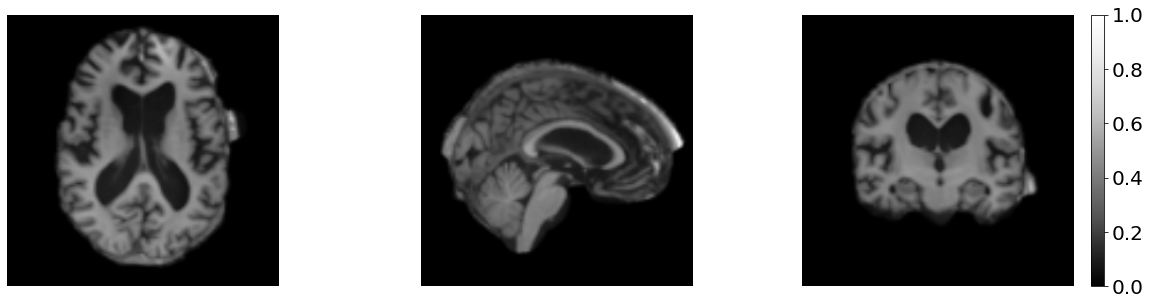

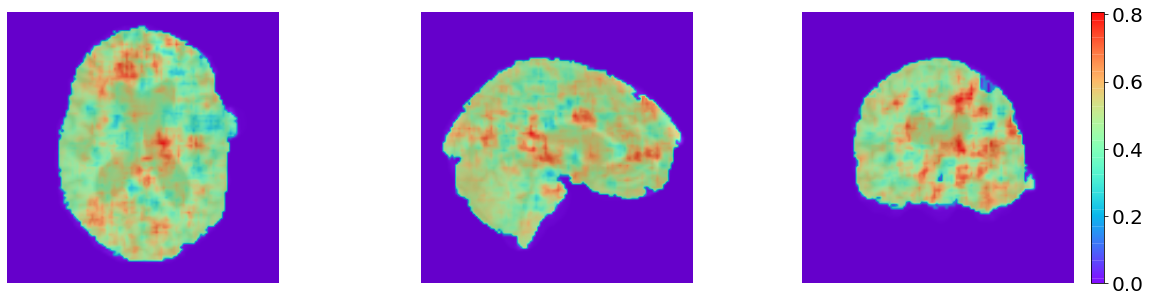

  0%|          | 0/19 [00:00<?, ?it/s]

passed gradientexplainer
shap index [[0 1]]
['example_level_00.npy', 'example_level_01.npy', 'example_level_02.npy', 'example_level_03.npy', 'example_level_04.npy', 'example_level_05.npy', 'example_level_06.npy', 'example_level_07.npy', 'example_level_08.npy', 'example_level_09.npy', 'example_level_10.npy', 'example_level_11.npy', 'example_level_12.npy', 'example_level_13.npy', 'example_level_14.npy', 'example_level_15.npy', 'example_level_16.npy', 'example_level_17.npy', 'example_level_18.npy']


100%|██████████| 19/19 [02:44<00:00,  8.66s/it]


3DUCM


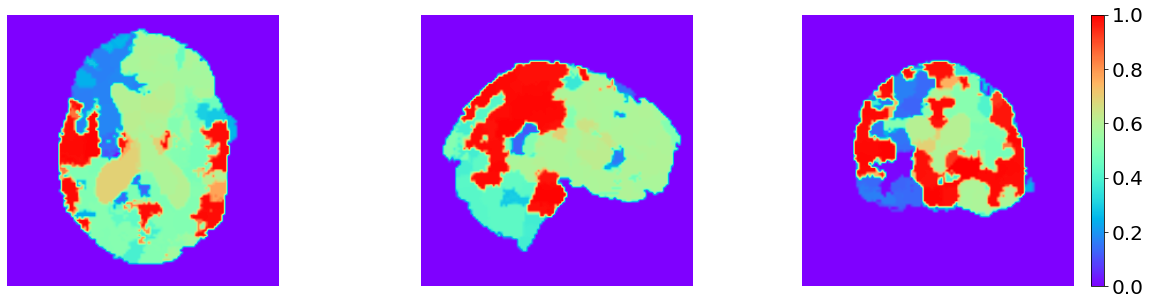


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



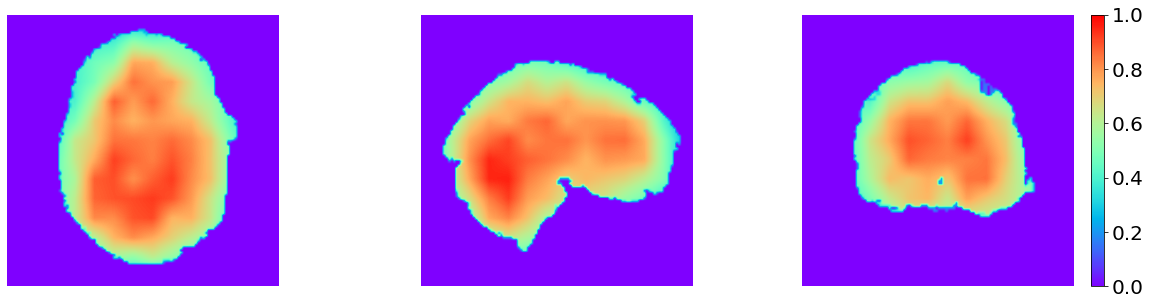

In [59]:
#YT load the example image

res_oc = np.load ("resnp.npy")
mx = nib.load('vimages\\example.nii').get_fdata().max(axis=0).max(axis=0).max(axis=0)
mri = np.array(nib.load('vimages\\example.nii').get_fdata()) / mx
#mri = data[30][0]
mri_rz = resize(mri,(256,256,256))

#Build model and best weights
#mod['model'] ='voxcnn'
if mod['model'] =='voxcnn' :
    modelRN = DefineVoxCNNModel (mod)
    modelRN.load_weights(os.path.join(outputpath,"voxcnnADCN5_20200501-145937_bestW.hdf5")) #Best weights so far
    res_oc = np.load ("vox_example.npy")
    lyr_name = 'conv3d_9'
else :
    modelRN = DefineResNetModel (mod)
    modelRN.load_weights(os.path.join(outputpath,"resnetADCN5_20200501-032129_bestW.hdf5")) #Best weights so far
    res_oc = np.load ("res_example.npy")
    lyr_name = 'voxres9_conv2'
    
modelRN.summary()

results= modelRN.predict(mri.reshape(1,1,110,110,110))
print ("predicted results:", results)
Print3Gray()
prob_map = copy.deepcopy(res_oc[:,:,:,0])
res_ocp = (prob_map - np.min(prob_map)) / (np.max(prob_map) - np.min(prob_map))
Print3Occ(res_ocp)

#YT Run shap
#e = shap.GradientExplainer(modelRN,  data, batch_size=5)
print ('passed gradientexplainer')
#shap_values, index = e.shap_values(mri.reshape(1,1,110,110,110),ranked_outputs=2)
print ("shap index", index)
#res_shap = copy.deepcopy(shap_values[0][0,0,:,:,:])
#Print3Occ(res_shap)

#YT Run 3DUCM 
res = Calc3DUCM(modelRN, mri)
print('3DUCM')
Print3DUCM(res)

#YT run 3D_GRAD_CAM
res_CAM = Calc_3D_Grad_CAM (modelRN, mri, layer_name = lyr_name)
#Print3DUCM(res_CAM)